In [1]:
import torch 
import torch.nn as nn
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

В 14 Мини ДЗ Вам предстоит самостоятельно сконструировать нейронную сеть и решить задачу классификации рукописных цифр. Можно использовать любую архитектуру и тип нейронных сетей - например полносвязные и/или сверточные.

Использование ноутбука с занятия приветствуется!

In [12]:
class ImageClassifier(nn.Module):
    def __init__(self, input_dim: int, hidden_dim1: int, hidden_dim2: int, num_classes: int):
        super().__init__()
        self.n_classes = num_classes
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, self.n_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, input_batch: torch.Tensor):
        output_batch = self.model(input_batch)

        return output_batch

Загрузим датасет:

In [13]:
train_dataset = torchvision.datasets.MNIST('.', download=True)
test_dataset = torchvision.datasets.MNIST('.', download=True, train=False)

train_x, train_y = train_dataset.train_data, train_dataset.train_labels
test_x, test_y = test_dataset.test_data, test_dataset.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
print('Размер тренировочной выборки:', train_x.shape[0])
print('Размер тестовой выборки:', test_x.shape[0])
print('Размер одного объекта:', test_x.shape[1:])

Размер тренировочной выборки: 60000
Размер тестовой выборки: 10000
Размер одного объекта: torch.Size([28, 28])


Теперь нужно определить нужные компоненты для тренировки:

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [39]:
model = ImageClassifier(
    input_dim=28*28, 
    hidden_dim1=128,
    hidden_dim2=64,
    num_classes=10,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [7]:
model

ImageClassifier(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=28, bias=True)
    (3): ReLU()
    (4): Linear(in_features=28, out_features=10, bias=True)
  )
)

А теперь train loop:

In [40]:
batch_size = 64  # Размер батча (столько объектов обрабатываются нейросетью за один forward pass)
losses = []
eval_losses = []
n_epochs = 100
accuracy_list = np.zeros((n_epochs,))

for epoch in range(n_epochs):
    model.train()
    current_epoch_train_losses = []
    for i in tqdm(range(0, train_x.shape[0], batch_size), 
                  desc='Training epoch {} from {}'.format(epoch, n_epochs)):
        x_batch = train_x[i: i + batch_size].to(device) # Здесь не забудьте перенести батч с данными на GPU
        y_batch = train_y[i: i + batch_size].to(device) # и здесь тоже

        x_batch = torch.flatten(x_batch.float(), start_dim=1)

        optimizer.zero_grad()

        model_output = model(x_batch)
        loss = criterion(model_output, y_batch)
        
        # Сделайте backward
        # Сделайте шаг градиентного спуска
        loss.backward()
        optimizer.step()

        current_epoch_train_losses.append(loss.item())
    losses.append(np.array(current_epoch_train_losses).mean())
    
    # Evaluation step
    model.eval()
    current_epoch_eval_losses = []
    for i in range(0, test_x.shape[0], batch_size):
        x_batch = test_x[i: i + batch_size].to(device)
        y_batch = test_y[i: i + batch_size].to(device)

        x_batch = torch.flatten(x_batch.float(), start_dim=1)

        with torch.no_grad():
            # Так как на валидации мы не оптимизируем модель, 
            # то нам не нужно считать градиенты. 
            # Поэтому мы воспользовалиь torch.no_grad(). 

            model_output = model(x_batch)
            #loss = (torch.argmax(model_output, dim=1) == y_batch).type(torch.float).mean()
            loss = criterion(model_output, y_batch)
            correct = (torch.argmax(model_output, dim=1) == y_batch).type(torch.float)
            accuracy_list[epoch] = correct.mean().item()

        current_epoch_eval_losses.append(loss.item())
    
    eval_losses.append(np.array(current_epoch_eval_losses).mean())

Training epoch 0 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 10 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 11 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 12 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 13 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 14 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 15 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 16 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 17 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 18 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 19 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 20 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 21 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 22 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 23 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 24 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 25 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 26 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 27 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 28 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 29 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 30 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 31 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 32 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 33 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 34 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 35 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 36 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 37 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 38 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 39 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 40 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 41 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 42 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 43 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 44 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 45 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 46 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 47 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 48 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 49 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 50 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 51 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 52 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 53 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 54 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 55 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 56 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 57 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 58 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 59 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 60 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 61 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 62 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 63 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 64 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 65 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 66 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 67 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 68 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 69 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 70 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 71 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 72 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 73 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 74 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 75 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 76 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 77 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 78 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 79 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 80 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 81 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 82 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 83 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 84 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 85 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 86 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 87 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 88 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 89 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 90 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 91 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 92 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 93 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 94 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 95 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 96 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 97 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 98 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 99 from 100:   0%|          | 0/938 [00:00<?, ?it/s]

Нарисуйте графики для train и val лоссов - какие выводы/наблюдения вы можете сделать по ним?

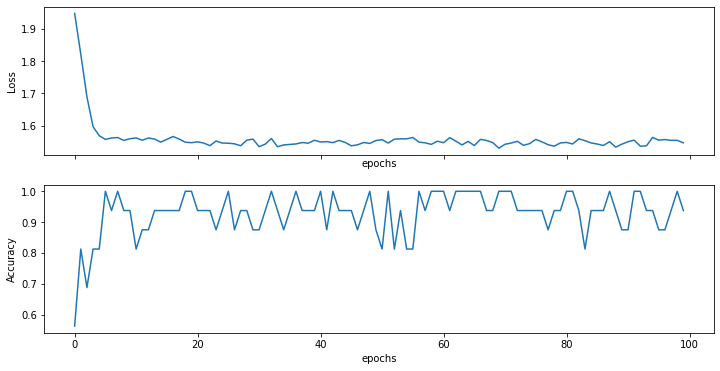

In [41]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(losses)
ax1.set_ylabel("Loss")
ax1.set_xlabel("epochs");

ax2.plot(accuracy_list)
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("epochs");

Посчитайте accuracy полученной модели. 

Постарайтесь получить accuracy 0.9, но начиная с 0.8 можно спокойно сдавать.

In [10]:
from sklearn.metrics import classification_report

In [42]:
with torch.no_grad():
    y_pred = np.argmax(model(x_batch).detach().cpu().numpy(), axis=1)

print(
    classification_report(
        y_batch.detach().cpu().numpy(), 
        y_pred
    )
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       0.50      1.00      0.67         1
           9       1.00      1.00      1.00         1

    accuracy                           0.94        16
   macro avg       0.95      0.95      0.93        16
weighted avg       0.97      0.94      0.94        16



Дополнительное задание:

Поэкспериментируйте с разными архитектурами (добавить батч нормализацию и дропаут) и гиперпарамтерами. Как изменилось качество модели? 